In [129]:
import sys
import os
import glob
import functools
from datetime import datetime
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline 
from matplotlib import pyplot as plt
from matplotlib.cm import viridis
import multiprocessing as mp
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

### Low level functions

In [2]:
base_path = '/mnt/sdb/ag_viz/Agriculture-Vision/'

In [3]:
label_dict = {0: 'background', 
              1: 'cloud_shadow', 
              2: 'double_plant', 
              3: 'planter_skip', 
              4: 'standing_water',
              5: 'waterway', 
              6: 'weed_cluster'}

In [4]:
def build_folder_paths(base_path, data_category):
    path_dict = {}
    path_home = os.path.join(base_path,data_category)
    path_dict['boundary'] = os.path.join(path_home, 'boundaries')
    path_dict['rgb'] = os.path.join(path_home, 'images/rgb')
    path_dict['nir'] = os.path.join(path_home, 'images/nir')
    path_dict['mask'] = os.path.join(path_home, 'masks')

    if data_category != 'test':
        for k,v in label_dict.items():
            if k != 0:
                path_dict[f'labels_{k}'] = os.path.join(path_home, 'labels/' + v)
    
    return path_dict

In [5]:
def get_file_paths(file_name, folder_dict):
    file_dict = {}
    
    for k,v in folder_dict.items():
        file_i = glob.glob(os.path.join(v, file_name + '*'))[0]
        file_dict[k] = file_i

    return file_dict
def get_file_paths_list(file_name, folder_dict):
    file_list = []
    
    for v in folder_dict.values():
        file_i = glob.glob(os.path.join(v, file_name + '*'))[0]
        file_list.append(file_i)

    return file_list

### Reading in images

In [6]:
def read_in_all_images(row_info):
    image_info = {}
    for k,v in row_info.items():
        image_info[k] = np.array(Image.open(v))
        
    return image_info

def read_in_image(row_info, image_type):
    return np.array(Image.open(row_info[image_type]))

### Functions for sampling of images

In [10]:
def parallel_image_info(image_name, image_type, folder_dict):
    file_info = get_file_paths(image_name, folder_dict)
    return read_in_image(file_info, image_type)

def parallel_all_image_info(image_name, folder_dict):
    file_info = get_file_paths(image_name, folder_dict)
    return read_in_all_images(file_info)

In [11]:
def get_random_many_images(width, height, image_names, image_type, folder_dict):
    num = width * height
    rand_image_names = np.random.choice(image_names, num, replace = False)
    
    with mp.Pool(processes = mp.cpu_count() - 1) as pool:
        images = pool.map(functools.partial(parallel_image_info, 
                                            image_type = image_type, 
                                            folder_dict = folder_dict), 
                          list(rand_image_names))
    
    fig, axes = plt.subplots(height, width, figsize=(20,16))
    for i,ax in enumerate(axes.flat):
        im = ax.imshow(images[i], vmin = 0, vmax = 255)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

In [20]:
def get_random_single_image(rows, image_names, folder_dict, plot = True):
    rand_image_names = np.random.choice(image_names, rows, replace = False)
    
    with mp.Pool(processes = mp.cpu_count() - 1) as pool:
        images = pool.map(functools.partial(parallel_all_image_info, 
                                            folder_dict = folder_dict), 
                          list(rand_image_names))
    
    if plot == True:
        key_order = list(images[0].keys())

        fig, axes = plt.subplots(rows, len(images[0]), figsize=(20,16))
        for i,ax in enumerate(axes.flat):
            image_type = key_order[i % len(images[0])]
            if image_type.find('label') != -1:
                image_type_title = label_dict[int(image_type[-1])]
            else:
                image_type_title = image_type
            if i // 10 == 0:
                ax.set_title(image_type_title)
            ax.imshow(images[i // 10][image_type], cmap = viridis, vmin = 0, vmax = 255)
    elif plot == False:
        return images

### Looking at some images

In [7]:
folder_dict = build_folder_paths(base_path, 'train')
list_image_names = [x[:-4] for x in os.listdir(folder_dict['rgb'])]

In [73]:
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    file_locations = pool.map(functools.partial(get_file_paths_list, folder_dict = folder_dict), list_image_names)

In [9]:
file_info = get_file_paths(list_image_names[0], folder_dict)
image_info = read_in_all_images(file_info)

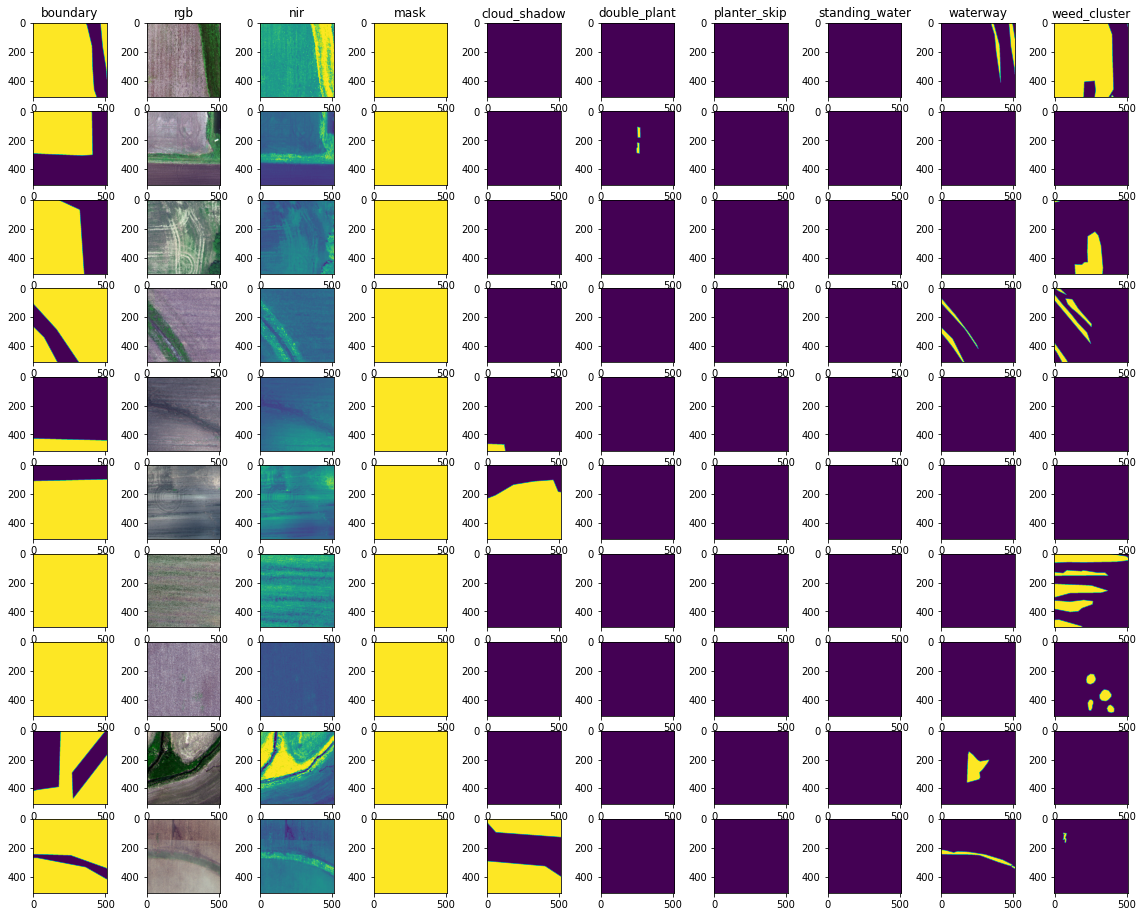

In [21]:
results = get_random_single_image(10, list_image_names, folder_dict, plot = False)
get_random_single_image(10, list_image_names, folder_dict, plot = True)

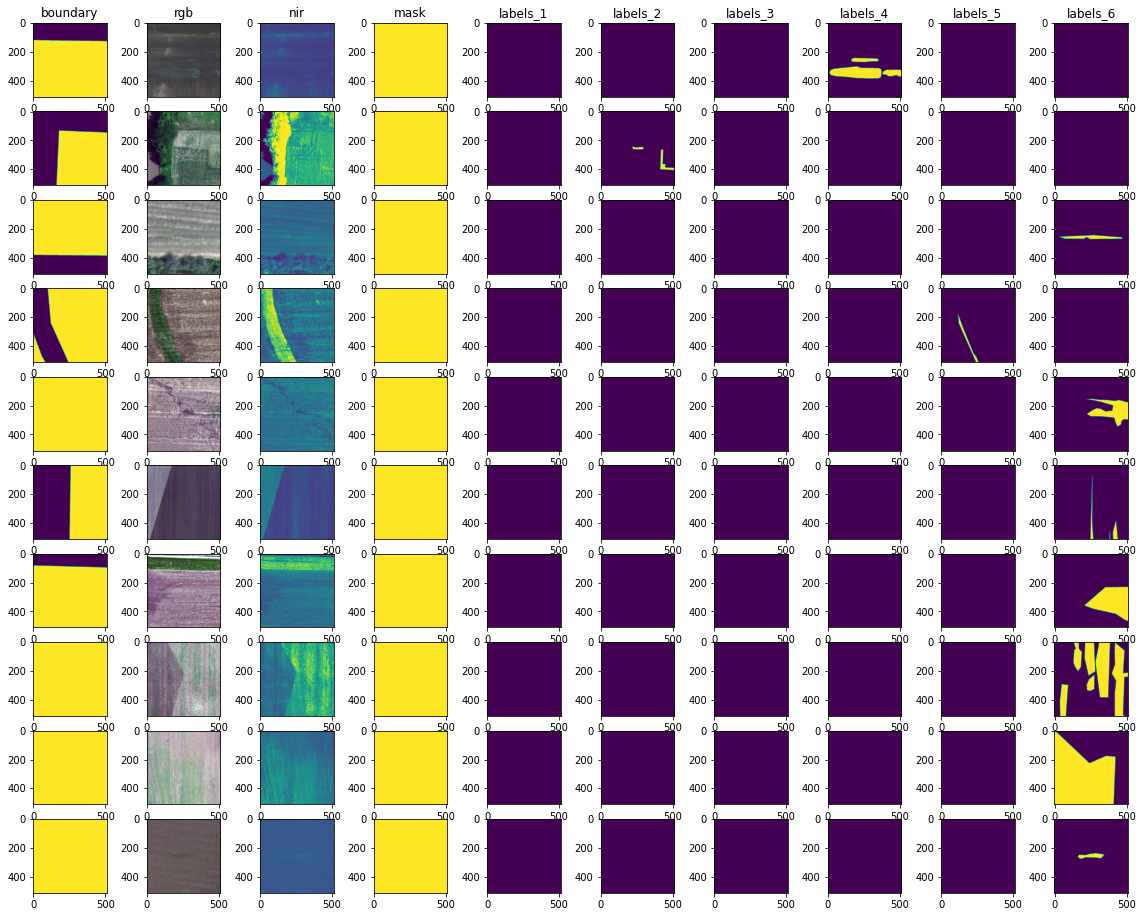

In [223]:
get_random_single_image(10, list_image_names, folder_dict, plot = True)

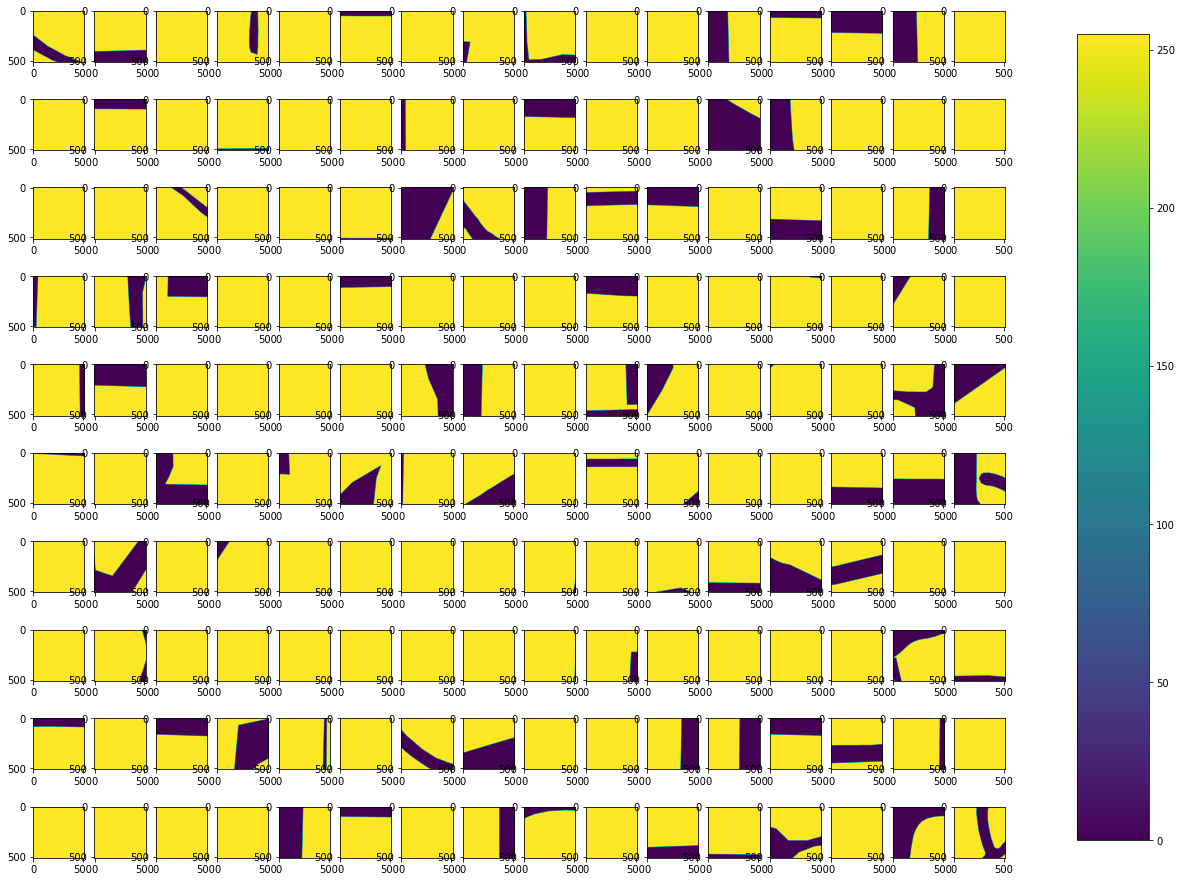

In [220]:
get_random_many_images(16, 10, list_image_names, 'boundary', folder_dict)

### Process data into TF

In [25]:
file_info

{'boundary': '/mnt/sdb/ag_viz/Agriculture-Vision/train/boundaries/6DLUEEKR4_760-6243-1272-6755.png',
 'rgb': '/mnt/sdb/ag_viz/Agriculture-Vision/train/images/rgb/6DLUEEKR4_760-6243-1272-6755.jpg',
 'nir': '/mnt/sdb/ag_viz/Agriculture-Vision/train/images/nir/6DLUEEKR4_760-6243-1272-6755.jpg',
 'mask': '/mnt/sdb/ag_viz/Agriculture-Vision/train/masks/6DLUEEKR4_760-6243-1272-6755.png',
 'labels_1': '/mnt/sdb/ag_viz/Agriculture-Vision/train/labels/cloud_shadow/6DLUEEKR4_760-6243-1272-6755.png',
 'labels_2': '/mnt/sdb/ag_viz/Agriculture-Vision/train/labels/double_plant/6DLUEEKR4_760-6243-1272-6755.png',
 'labels_3': '/mnt/sdb/ag_viz/Agriculture-Vision/train/labels/planter_skip/6DLUEEKR4_760-6243-1272-6755.png',
 'labels_4': '/mnt/sdb/ag_viz/Agriculture-Vision/train/labels/standing_water/6DLUEEKR4_760-6243-1272-6755.png',
 'labels_5': '/mnt/sdb/ag_viz/Agriculture-Vision/train/labels/waterway/6DLUEEKR4_760-6243-1272-6755.png',
 'labels_6': '/mnt/sdb/ag_viz/Agriculture-Vision/train/labels/weed_

In [8]:
# Sourced from challenge winner - https://github.com/th2l/Agriculture-Vision-Segmentation/blob/master/main.py
def gpu_process_image_dev(file_info, folder_dict):
    folder_names = {x:i for i,x in enumerate(list(folder_dict.keys()))}
    # Read RGB
    rgb_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['rgb']]), channels=3)

    # Read NIR
    nir_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['nir']]), channels=1)

    # Concat rgb and nir to NRGB
    nrgb_image = tf.concat([nir_image, rgb_image], axis=2)  # 512 x 512 x 4

    # Read boundary
    bdr_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['boundary']]), channels=1)

    # Read mask
    msk_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['mask']]), channels=1)

    invalid_pixels = tf.logical_or(bdr_image == 0, msk_image == 0)

    nrgb_image = tf.where(invalid_pixels, tf.zeros_like(nrgb_image), nrgb_image)
    nrgb_image = tf.image.convert_image_dtype(nrgb_image, tf.float32)
    
    ld_labels = {0: tf.identity(invalid_pixels)}
    
    for idx in range(1, len(label_dict)):
        # Read label
        current_label = tf.image.decode_image(tf.io.read_file(file_info[folder_names[f'labels_{idx}']]), channels=1)

        ld_labels[idx] = tf.logical_and(current_label > 0, tf.logical_not(invalid_pixels))
        ld_labels[0] = tf.logical_or(ld_labels[idx], ld_labels[0])
        

    ld_labels[0] = tf.logical_not(ld_labels[0])

    ret_label = tf.cast(tf.concat(
        [ld_labels[0], ld_labels[1], ld_labels[2], ld_labels[3], ld_labels[4], ld_labels[5], ld_labels[6],
        invalid_pixels], axis=2), dtype=tf.int32)  # 512 x 512 x 8

    nrgb_image.set_shape((512, 512, 4))
    ret_label.set_shape((512, 512, 8))

    return nrgb_image, ret_label


In [12]:
folder_dict = build_folder_paths(base_path, 'train')
list_image_names = [x[:-4] for x in os.listdir(folder_dict['rgb'])]
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    file_locations = pool.map(functools.partial(get_file_paths_list, folder_dict = folder_dict), list_image_names)
    
process_train = lambda x: gpu_process_image_dev(x, folder_dict = folder_dict)
train_ds = (tf.data.Dataset.from_tensor_slices(np.array(file_locations))
            .map(process_train)
            .batch(8)
            .repeat()
            .prefetch(8))

In [158]:
folder_dict = build_folder_paths(base_path, 'val')
list_image_names = [x[:-4] for x in os.listdir(folder_dict['rgb'])]
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    file_locations = pool.map(functools.partial(get_file_paths_list, folder_dict = folder_dict), list_image_names)
process_val = lambda x: gpu_process_image_dev(x, folder_dict = folder_dict)
val_ds = (tf.data.Dataset.from_tensor_slices(np.array(file_locations))
            .map(process_val)
            .batch(8)
            .repeat()
            .prefetch(8))
val_ds_final = (tf.data.Dataset.from_tensor_slices(np.array(file_locations))
            .map(process_val)
            .batch(64))

In [14]:
print('train data: ' + str(train_ds))
print('validation data: ' + str(val_ds))

train data: <PrefetchDataset shapes: ((None, 512, 512, 4), (None, 512, 512, 8)), types: (tf.float32, tf.int32)>
validation data: <PrefetchDataset shapes: ((None, 512, 512, 4), (None, 512, 512, 8)), types: (tf.float32, tf.int32)>


### Model Preparation

In [178]:
encoder = tfk.Sequential([
  tfkl.InputLayer((512,512,4)),
  tfkl.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(16, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02), 
])
encoder.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 512, 512, 128)     4736      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 256, 256, 128)     0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 256, 256, 64)      73792     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 128, 64)    

In [184]:
decoder = tfk.Sequential([
  tfkl.InputLayer(encoder.output.shape[1:]),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(8, (3,3), activation = 'sigmoid', padding = 'same')
])
decoder.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 32, 32, 64)        9280      
_________________________________________________________________
up_sampling2d_44 (UpSampling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
up_sampling2d_45 (UpSampling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 128, 128, 32)    

In [185]:
x = tfkl.Input((512,512,4))
h = encoder(x)
xhat = decoder(h)
h, xhat

(<tf.Tensor 'sequential_21/dropout_69/cond_1/Identity:0' shape=(None, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'sequential_25/conv2d_100/Sigmoid:0' shape=(None, 512, 512, 8) dtype=float32>)

In [186]:
multi_predictor = tfk.Model(inputs=x, outputs=xhat)
multi_predictor.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 512, 512, 4)]     0         
_________________________________________________________________
sequential_21 (Sequential)   (None, 32, 32, 16)        124688    
_________________________________________________________________
sequential_25 (Sequential)   (None, 512, 512, 8)       48552     
Total params: 173,240
Trainable params: 173,240
Non-trainable params: 0
_________________________________________________________________


In [192]:
# training happens as usual
multi_predictor.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

results = multi_predictor.fit(train_ds, steps_per_epoch=50, epochs=20, 
                          validation_data = val_ds,
                          validation_steps = 1,
          callbacks=[tensorboard_callback])

Epoch 1/20
50/50 [==============================] - 8s 156ms/step - loss: 0.1532 - val_loss: 0.1799
Epoch 2/20
50/50 [==============================] - 8s 153ms/step - loss: 0.1454 - val_loss: 0.1669
Epoch 3/20
50/50 [==============================] - 8s 154ms/step - loss: 0.1404 - val_loss: 0.1757
Epoch 4/20
50/50 [==============================] - 8s 155ms/step - loss: 0.1394 - val_loss: 0.1769
Epoch 5/20
50/50 [==============================] - 8s 155ms/step - loss: 0.1429 - val_loss: 0.1626
Epoch 6/20
50/50 [==============================] - 8s 155ms/step - loss: 0.1453 - val_loss: 0.1472
Epoch 7/20
50/50 [==============================] - 8s 156ms/step - loss: 0.1376 - val_loss: 0.1578
Epoch 8/20
50/50 [==============================] - 8s 157ms/step - loss: 0.1341 - val_loss: 0.1623
Epoch 9/20
50/50 [==============================] - 8s 158ms/step - loss: 0.1325 - val_loss: 0.1583
Epoch 10/20
50/50 [==============================] - 8s 159ms/step - loss: 0.1249 - val_loss: 0.1709

### Model Evaluation

In [193]:
x, y = next(iter(val_ds))
y_pred = multi_predictor.predict(x)

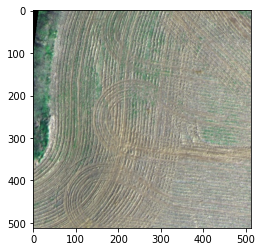

In [194]:
plt.imshow(x[2,:,:,1:])

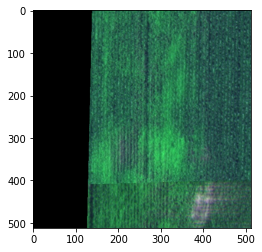

In [217]:
plt.imshow(x[0,:,:,1:])

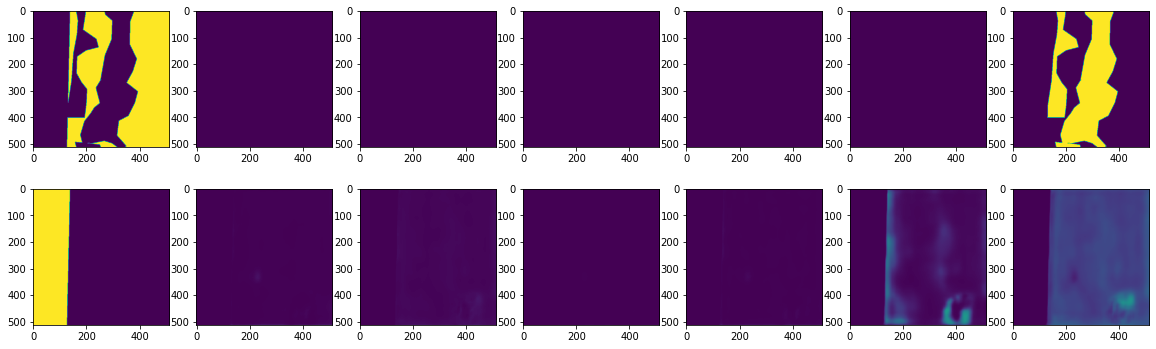

In [219]:
fig, axes = plt.subplots(2, 7, figsize=(20,6))
for i,ax in enumerate(axes.flat):
    if i <= 7: 
        ax.imshow(y[0,:,:, i])
    else:
        ax.imshow(y_pred[0,:,:,i % 7], vmin=0,vmax=1)

In [220]:
class AgrVimIOU(tf.keras.metrics.Metric):
    """ Modified mIOU as in Agriculture-Vision challenge 
        Sourced from: https://github.com/th2l/Agriculture-Vision-Segmentation
    """
    def __init__(self, name='AgrVimIOU', num_classes=7, per_classes=False):
        super(AgrVimIOU, self).__init__(name=name)
        self.num_classes = num_classes
        self.arr_mult = tf.range(1, self.num_classes + 1, dtype=tf.float32)

        self.total_true_positive = self.add_weight(
            'total_true_positive',
            shape=(self.num_classes,),
            initializer=tf.zeros_initializer,
            dtype=tf.float64)

        self.total_union = self.add_weight(
            'total_union',
            shape=(self.num_classes,),
            initializer=tf.zeros_initializer,
            dtype=tf.float64)
        self.per_classes = per_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        :param y_true: batch_size x 512 x 512 x 8
        :param y_pred: batch_size x 512 x 512
        :param sample_weight:
        :return:
        """
        invalid_pixels = tf.expand_dims(tf.cast(y_true[:, :, :, -1], tf.bool), -1)  # Index of invalid pixels

        y_true_onehot = tf.cast(y_true[:, :, :, :-1], tf.float32)
        
        y_pred_onehot = tf.one_hot(tf.argmax(tf.nn.softmax(y_pred, axis=-1), axis=-1), depth=self.num_classes, axis=-1, dtype=tf.float32)

        overlap = tf.reduce_sum(tf.multiply(y_true_onehot, y_pred_onehot), axis=-1, keepdims=True)

        y_pred_onehot = tf.where(tf.logical_or(tf.equal(overlap, 1), invalid_pixels), y_true_onehot, y_pred_onehot)

        current_true_positive = tf.cast(tf.reduce_sum(tf.multiply(y_pred_onehot, y_true_onehot), axis=[0, 1, 2]), tf.float64)
        current_union = tf.cast(tf.reduce_sum(y_pred_onehot + y_true_onehot, axis=[0, 1, 2]), tf.float64) - current_true_positive

        self.total_true_positive.assign_add(current_true_positive)
        self.total_union.assign_add(current_union)
        

    def result(self):
        """Compute the mean intersection-over-union via the confusion matrix."""

        num_valid_entries = tf.cast(tf.reduce_sum(tf.cast(tf.not_equal(self.total_union, 0), tf.int32)), tf.float64)

        iou = tf.math.divide_no_nan(self.total_true_positive, self.total_union)

        if self.per_classes:
            tf.print(iou, summarize=-1)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='agrvi_mean_iou'), num_valid_entries)

    def reset_states(self):
        tf.keras.backend.set_value(self.total_true_positive, np.zeros((self.num_classes)))
        tf.keras.backend.set_value(self.total_union, np.zeros((self.num_classes)))

    def get_config(self):
        return {'name': self.name, 'num_classes': self.num_classes}

    @classmethod
    def from_config(cls, config):
        """Instantiates a `Loss` from its config (output of `get_config()`).
        Args:
            config: Output of `get_config()`.
        Returns:
            A `Loss` instance.
        """
        return cls(**config)

In [221]:
val_mIOU = AgrVimIOU(num_classes=7, per_classes=True)

for x, y in tqdm(iter(val_ds_final)):
    y_ = multi_predictor.predict(x)
    val_mIOU.update_state(y, y_)

70it [01:01,  1.14it/s]


In [222]:
val_mIOU.result()

[0.74829020551747061 0.0013372490880442639 0 0.0013745055132604734 5.02016163541932e-05 0.3661310022270241 0.34848415995646204]


<tf.Tensor: shape=(), dtype=float64, numpy=0.20938104627408796>